# Dataset
This Dataset has been obtained from Kaggle. <br/>

In [1]:
!pip install kaggle

In [3]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# API to fetch the dataset from Kaggle

!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

 99% 1.75G/1.76G [00:24<00:00, 120MB/s] 
100% 1.76G/1.76G [00:24<00:00, 75.6MB/s]


In [6]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/lung-and-colon-cancer-histopathological-images.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>.Introduction</a></span></li><li><span><a href="#Lung-cancer-dataset" data-toc-modified-id="Lung-cancer-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>.Lung Cancer Dataset</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>.Model</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>.Results</a></span></li><li><span><a href="#Wrongly-classified-samples" data-toc-modified-id="Wrongly-classified-samples-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>.Wrongly classified samples</a></span></li><li><span><a href="#Results-discussion" data-toc-modified-id="Results-discussion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>.Results discussion</a></span></li><li><span><a href="#ResNet50" data-toc-modified-id="ResNet50-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>.ResNet50</a></span></li><li><span><a href="#References-and-links" data-toc-modified-id="References-and-links-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>.References and links</a></span></li></ul></div>

# Introduction
This notebook explores Lung and Colon Cancer Histopathological Image Dataset (LC25000) with the focus on lung cancer images only. <br/>


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt



In [12]:
# check for sure if channels should be last - it was changing due to some import
K.image_data_format() == 'channels_first'

False

# The Lung Cancer Dataset - LC25000

The dataset contains 25,000 color images with five classes of 5,000
images each. All images are 768 x 768 pixels in size and are in jpeg
file format. The main folder
lung_colon_image_set contains two subfolders: colon_image_sets
and lung_image_sets.

The subfolder colon_image_sets contains two secondary subfolders:
- colon_aca subfolder with 5,000 images of colon adenocarcinomas
- colon_n subfolder with 5,000 images of benign colonic tissues.


The subfolder lung_image_sets contains three secondary subfolders:
- lung_aca subfolder with 5,000 images of lung adenocarcinomas
- lung_scc subfolder with 5,000 images of lung squamous cell carcinomas
- lung_n subfolder with 5,000 images of benign lung tissues.

Here I use only lung tissues images. The images are huge so I resize them right away to 80x80x3 size. Not to worry about imbalanced classes here - authors of database took care of them having same number of samples. Important thing to note is that some of the pictures come from augmentation as authors mentioned it in the paper https://arxiv.org/ftp/arxiv/papers/1912/1912.12142.pdf

In [13]:
import cv2
import os

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)

    return np.array(images)

In [15]:
benign = load_images('/content/lung_colon_image_set/lung_image_sets/lung_n/')
mal_aca = load_images('/content/lung_colon_image_set/lung_image_sets/lung_aca/')
mal_scc = load_images('/content/lung_colon_image_set/lung_image_sets/lung_scc/')

In [16]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}, SQUAMOS CELL CARCINOMAS {mal_scc.shape[0]}.")

print(f"Images shape: {benign[0].shape}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000, SQUAMOS CELL CARCINOMAS 5000.
Images shape: (80, 80, 3).


<ipython-input-17-738521bdd1e4>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n+1, 3, 1)
<ipython-input-17-738521bdd1e4>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n+1, 3, 2)
<ipython-input-17-738521bdd1e4>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n+1, 3, 3)


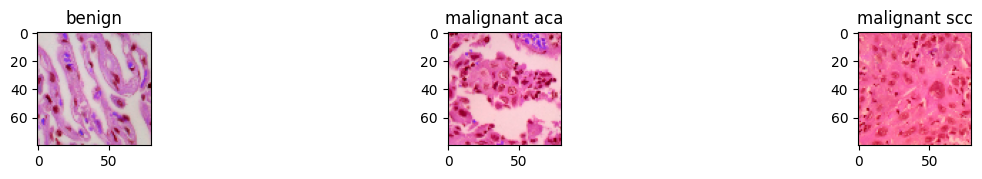

In [17]:
indices = [0, 40, 2300]

plt.figure(1, figsize=(15,5))
plt.grid(None)

for n, idx in enumerate(indices):
    plt.subplot(n+1, 3, 1)
    plt.imshow(benign[idx])
    plt.title('benign')
    plt.subplot(n+1, 3, 2)
    plt.imshow(mal_aca[idx])
    plt.title('malignant aca')
    plt.subplot(n+1, 3, 3)
    plt.imshow(mal_scc[idx])
    plt.title('malignant scc')

plt.show()

Make datasets - concatenate images from three classes and create labels for them. Samples shape should be 15000x80x80x3, labels 15000. They are stacked together so next step is shuffling both of them randomly. Important thing to normalize pictures as usual to [0,1] range by dividing them by 255 (the pixel values can range from 0 to 256). When using the image as it is and passing through a deep neural network, the computation of high numeric values would be more complex and slower.

In [18]:
samples = np.concatenate((benign, mal_aca, mal_scc))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] + mal_scc.shape[0] * [2])

In [19]:
print(f"Samples shape check: {samples.shape}.")
print(f"Labels shape check: {labels.shape}.")


Samples shape check: (15000, 80, 80, 3).
Labels shape check: (15000,).


In [20]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures
samples = samples.astype('float32') / 255

Split data. Here 15000 samples are in fact not so many so standard 80/20 division is introduced. From test data, which is 20%, validation set is further obtained by splitting it 50/50. So train set is 80% of images, validation set is 10% and test set is 10%.

Labels are one hot encoded to be categorical values.

In [22]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [24]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, 3)
Y_val = to_categorical(y_val, 3)
Y_test = to_categorical(y_test, 3)

print(Y_train[0])
print(f"Y_train shape after one hot encoding: {Y_val.shape}")
print(f"Y_train shape after one hot encoding: {X_val.shape}")

[0. 0. 1.]
Y_train shape after one hot encoding: (1500, 3)
Y_train shape after one hot encoding: (1500, 80, 80, 3)


# Model
CNN is used to test image classification consisting of input layer, three hidden conv layers with filter 3x3 each followed by maxpooling with filter 2x2 and dropout 0.2, one fully connected layer and one output layer with 3 units and softmax activation function. For hidden layers relu was used as activation function.

In [26]:
def base_model(input_shape=(80,80,3), classes=3):
    '''
    CNN base model with 4 hidden layers (3 conv and one fully connected)
    '''
    inputs = Input(shape=input_shape)

    X = Conv2D(32, 3, 3, activation='relu')(inputs)
    X = MaxPooling2D(pool_size=(2,2))(X)

    X = Conv2D(64, 3, 3, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(128, 3, 3, activation='relu', padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), padding='same')(X)
    X = Dropout(0.2)(X)

    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    outputs = Dense(classes, activation='softmax')(X)

    model = Model(inputs, outputs)

    return model

In [27]:
model = base_model(input_shape=(80,80,3), classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0     

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [29]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=25, validation_data=(X_val, Y_val))

Epoch 1/25
188/188 [==============================] - 15s 12ms/step - loss: 0.4590 - accuracy: 0.7945 - val_loss: 0.3087 - val_accuracy: 0.8773
Epoch 2/25
188/188 [==============================] - 2s 10ms/step - loss: 0.3127 - accuracy: 0.8662 - val_loss: 0.2688 - val_accuracy: 0.8893
Epoch 3/25
188/188 [==============================] - 2s 10ms/step - loss: 0.2611 - accuracy: 0.8906 - val_loss: 0.1966 - val_accuracy: 0.9193
Epoch 4/25
188/188 [==============================] - 2s 8ms/step - loss: 0.2219 - accuracy: 0.9044 - val_loss: 0.2186 - val_accuracy: 0.9047
Epoch 5/25
188/188 [==============================] - 2s 8ms/step - loss: 0.2044 - accuracy: 0.9167 - val_loss: 0.1469 - val_accuracy: 0.9373
Epoch 6/25
188/188 [==============================] - 1s 8ms/step - loss: 0.1842 - accuracy: 0.9251 - val_loss: 0.1498 - val_accuracy: 0.9467
Epoch 7/25
188/188 [==============================] - 2s 8ms/step - loss: 0.1658 - accuracy: 0.9348 - val_loss: 0.1351 - val_accuracy: 0.9487
Ep

<ipython-input-30-d1a414836719>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


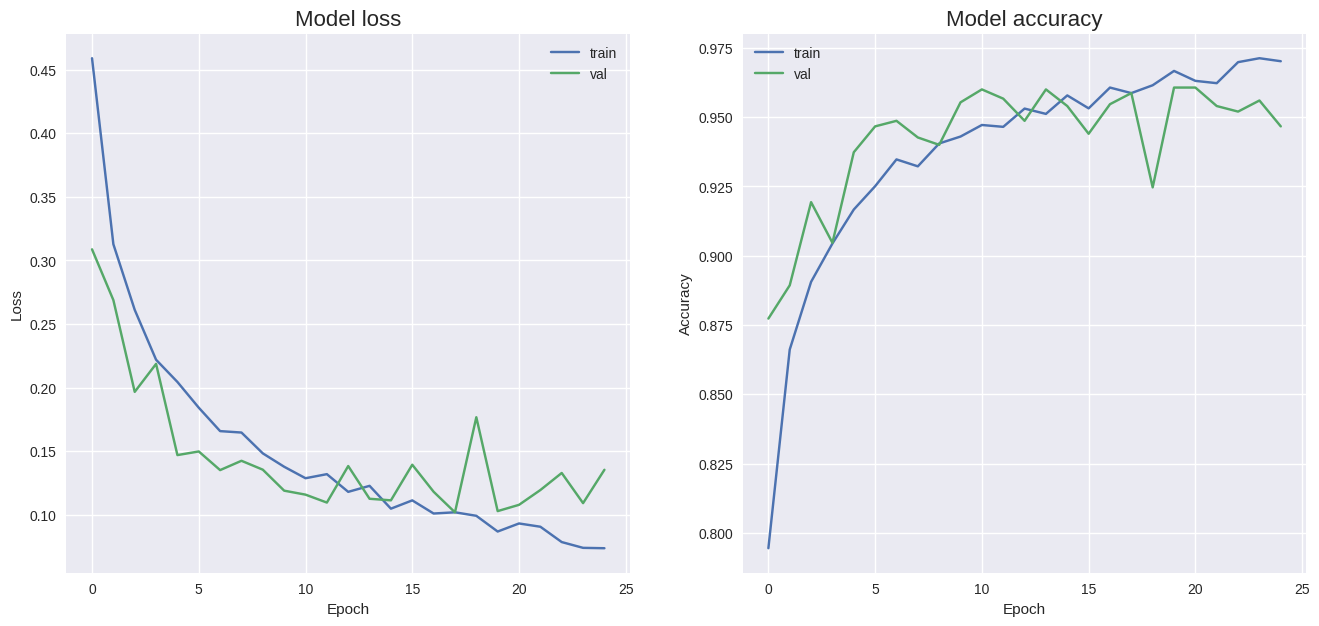

In [30]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=16)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])

plt.show()

In [31]:
y_pred_test = model.predict(X_test, verbose=1)
y_pred_train = model.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

score_test = model.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

47/47 [==============================] - 0s 5ms/step - loss: 0.1341 - accuracy: 0.9547
Train accuracy: 0.970
Validation accuracy: 0.947
Test accuracy: 0.955


<Axes: >

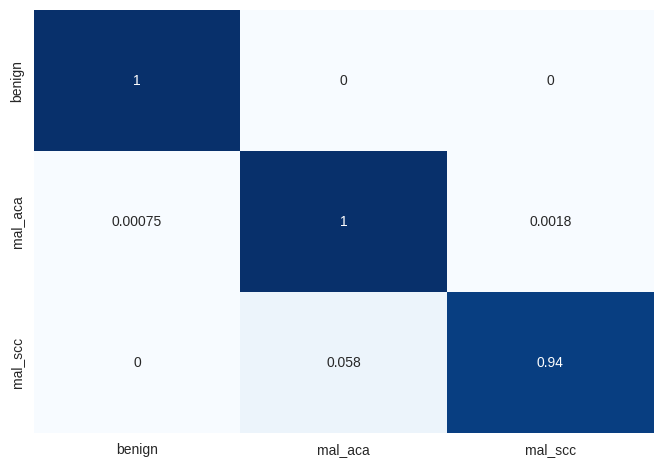

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False,
           xticklabels=label_names, yticklabels=label_names)

# Wrongly classified samples
Here I've decided to explore some samples that model didn't get right. Most problems model had with mal_aca class, it mistook it for mal_scc.

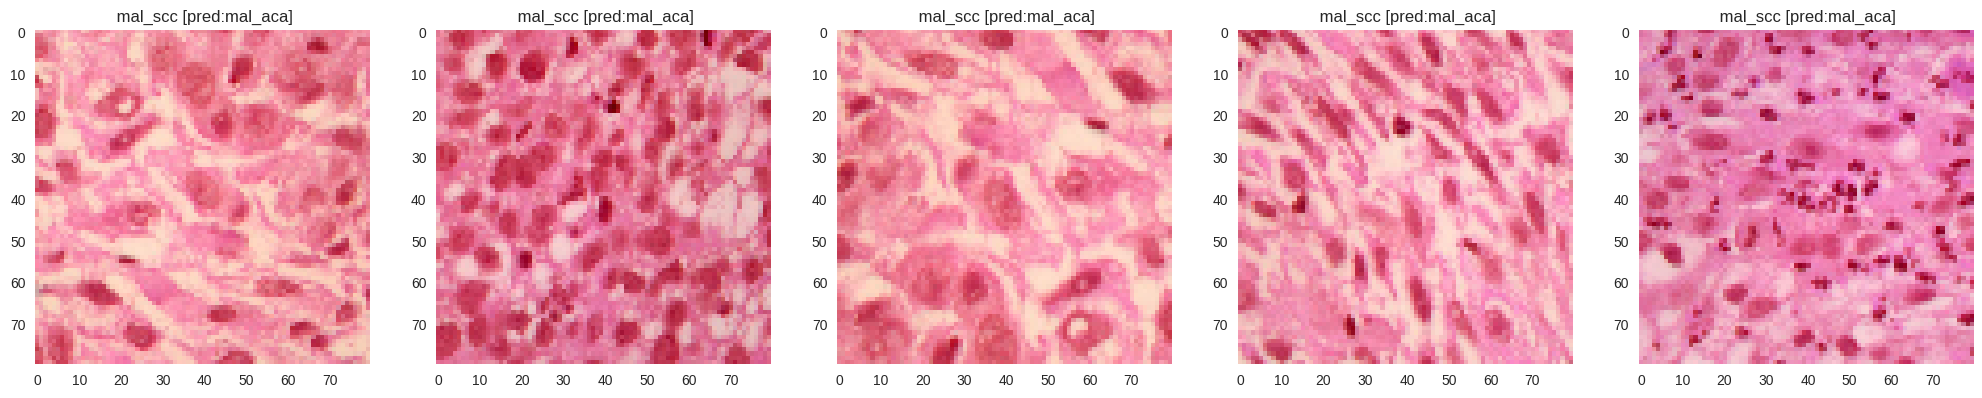

In [33]:
mistakes = np.where(y_pred_train != y_train)[0]

n = 5

plt.figure(figsize=(5*n,5))

# get 5 random false negatives
for i, val in enumerate(np.random.choice(mistakes, n)):

    plt.subplot(1,n,i+1)
    plt.imshow(X_train[val])
    plt.title(f" {label_names[y_train[val]]} [pred:{label_names[y_pred_train[val]]}]", fontsize=12)
    plt.grid(None)


Data seems to not be problematic, images are of high quality. However I wonder what human error would be on them. For me they certainly look different, for experienced doctor it wouldn't be a problem differentiating between benign and malignant I believe. Benign tissue doesn't have so much cells closely placed like in the malignant tissues and benign has far more red cells. About differentating one cancer (ACA) from another type (SCC) I'm not sure. SCC cells are more packed together and maybe are smaller than those in ACA images.



# ResNet50

So I think that the CNN could definietly be deeper to reduce bias. In deeper layers model could explore differences between cancers that I don't know about.

Here it is a bit extreme example - I use ResNet50, which is very deep (50 layers), following original architecture CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER.

ResNet uses residual connections - for deep NN there is a problem with vanishing gradients. As you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero. Residual connections are like shortcuts for activation functions through layers, they allow model to learn identity function very quickly. They prevent vanishing gradient problem and therefore doesn't hurt trainig performance.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same (identity_block) or different (convolutional_block).

In [34]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X


    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding='same', name= conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3, name= bn_name_base + '2c')(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)


    return X

In [35]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same',name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1), strides = (1,1), padding='valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding='valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)


    return X

In [36]:
def ResNet50(input_shape=(80, 80, 3), classes=3):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)


    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)


    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, 3, [128,128,512], stage=3, s=2, block='a')
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    X = convolutional_block(X, 3, [256,256,1024], stage=4, s=2, block='a')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')


    X = convolutional_block(X, 3, [512,512,2048], stage=5, s=2, block='a')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')


    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [37]:
from keras.initializers import glorot_uniform
resmodel = ResNet50(input_shape=(80, 80, 3), classes=3)

In [38]:
resmodel.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 86, 86, 3)            0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 40, 40, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 40, 40, 64)           256       ['conv1[0][0]']        

In [39]:
resmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [43]:
resNET_history = resmodel.fit(X_train, Y_train, batch_size = 64, epochs = 20, validation_data=(X_val, Y_val))

Epoch 1/20
188/188 [==============================] - 24s 125ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.0924 - val_accuracy: 0.9680
Epoch 2/20
188/188 [==============================] - 23s 122ms/step - loss: 0.0155 - accuracy: 0.9942 - val_loss: 0.1631 - val_accuracy: 0.9647
Epoch 3/20
188/188 [==============================] - 22s 118ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.3988 - val_accuracy: 0.9060
Epoch 4/20
188/188 [==============================] - 22s 116ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 1.1818 - val_accuracy: 0.8280
Epoch 5/20
188/188 [==============================] - 22s 119ms/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.8049 - val_accuracy: 0.8907
Epoch 6/20
188/188 [==============================] - 22s 118ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.8989 - val_accuracy: 0.8267
Epoch 7/20
188/188 [==============================] - 23s 120ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.8339 - val_ac

<ipython-input-47-862df64a62f4>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


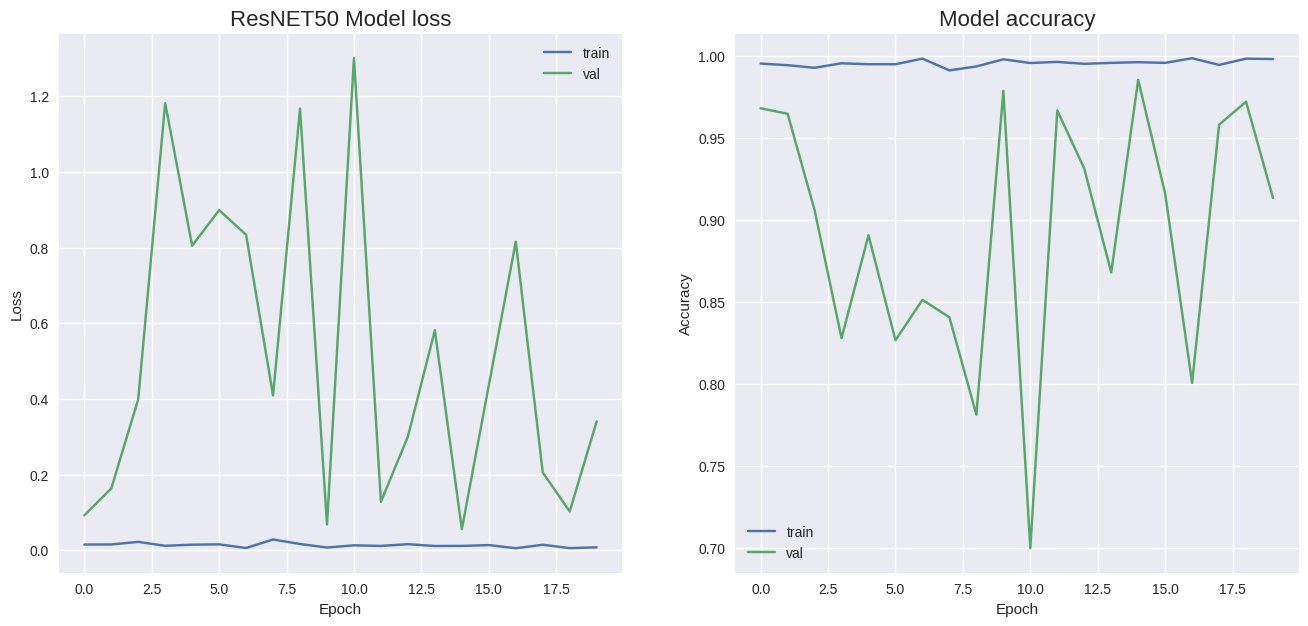

In [47]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(resNET_history.history['loss'])
plt.plot(resNET_history.history['val_loss'])
plt.title('ResNET50 Model loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(resNET_history.history['accuracy'])
plt.plot(resNET_history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=16)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])

plt.show()

In [49]:
y_pred_test_resNet50 = model.predict(X_test, verbose=1)
y_pred_train_resNet50 = model.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test_resNet50 = np.argmax(y_pred_test_resNet50, axis=1)
y_pred_train_resNet50 = np.argmax(y_pred_train_resNet50, axis=1)

score_test_resNet50 = model.evaluate(X_test, Y_test)
print(f"Train accuracy: {resNET_history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {resNET_history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test_resNet50[1]:.3f}")

47/47 [==============================] - 0s 4ms/step - loss: 0.1341 - accuracy: 0.9547
Train accuracy: 0.998
Validation accuracy: 0.913
Test accuracy: 0.955


<Axes: >

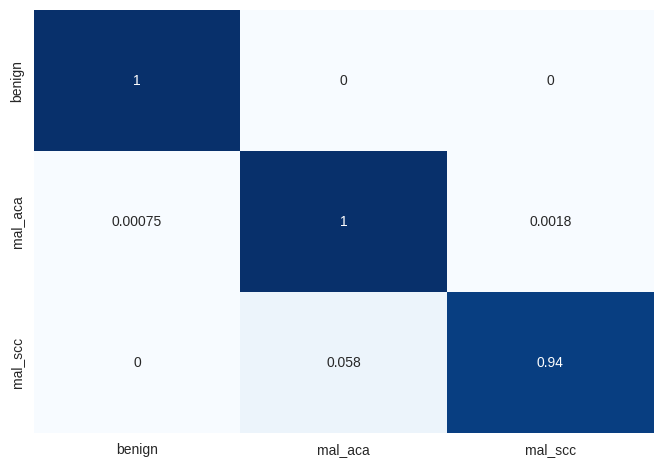

In [50]:
label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train_resNet50, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False,
           xticklabels=label_names, yticklabels=label_names)

[1] Lung and Colon Cancer Histopathological Image Dataset (LC25000)
Andrew A. Borkowski, MD, Marilyn M. Bui, MD, PhD, L. Brannon Thomas, MD, PhD,
Catherine P. Wilson, MT, Lauren A. DeLand, RN, Stephen M. Mastorides, MD


[2] Tried to find histologic differences between two cancers, came across this:
- https://www.pathologyoutlines.com/topic/lungtumoradenocarcinoma.html
- https://www.pathologyoutlines.com/topic/lungtumorSCC.html

[3] If you want to know more about patients with those two types of cancer and how it affect te survival:
Differences Between Squamous Cell Carcinoma and Adenocarcinoma of the Lung: Are Adenocarcinoma and Squamous Cell Carcinoma Prognostically Equal?
Akikazu Kawase, Junji Yoshida, Genichiro Ishii, Masayuki Nakao, Keiju Aokage, Tomoyuki Hishida, Mitsuyo Nishimura, Kanji Nagai
https://academic.oup.com/jjco/article/42/3/189/1015061